# Train a very simple model

In [1]:
DATA_TRAIN_PATH = 'data/train'
DATA_TEST_PATH = 'data/test'
LABELS_TRAIN_PATH = 'data/labels_10k.csv'
LABELS_TEST_PATH = 'data/labels_test.csv'

In [2]:
import pandas as pd
import numpy as np
import os

### Load data from disk

In [3]:
df_labels_train = pd.read_csv(LABELS_TRAIN_PATH)
df_labels_test = pd.read_csv(LABELS_TEST_PATH)
print(df_labels_train)

      Unnamed: 0  label
0              0      5
1              1      0
2              2      4
3              3      1
4              4      9
...          ...    ...
9995        9995      5
9996        9996      8
9997        9997      6
9998        9998      9
9999        9999      7

[10000 rows x 2 columns]


In [4]:
def load_data(df_labels, dirpath):
    data = []
    for i, row in df_labels.iterrows():
        loadpath = os.path.join(dirpath, f'{i}.npy')
        img = np.load(loadpath)
        data.append(img)
    return np.array(data)

data_train = load_data(df_labels_train, DATA_TRAIN_PATH)
data_test = load_data(df_labels_test, DATA_TEST_PATH)

In [5]:
print(data_train.shape, data_test.shape)

(10000, 28, 28) (10000, 28, 28)


### Make a train/val split

In [6]:
from sklearn.model_selection import train_test_split

labels_train_array = df_labels_train['label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_train, labels_train_array, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (8000, 28, 28)
Validation set shape: (2000, 28, 28)


### Look at a few examples

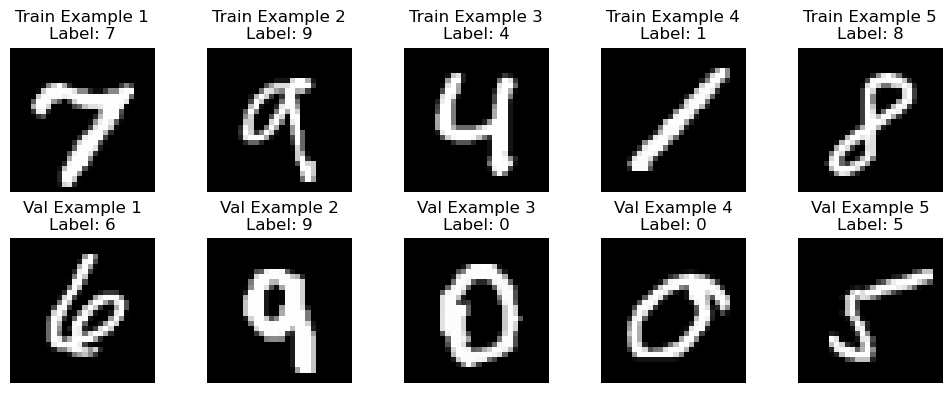

In [7]:
import matplotlib.pyplot as plt

# Define the number of random examples to display
num_examples = 5

# Randomly select examples and corresponding labels from the training set
train_indices = np.random.choice(len(X_train), num_examples, replace=False)
train_examples = X_train[train_indices]
train_labels = y_train[train_indices]

# Randomly select examples and corresponding labels from the validation set
val_indices = np.random.choice(len(X_val), num_examples, replace=False)
val_examples = X_val[val_indices]
val_labels = y_val[val_indices]

# Plot the random examples from the training set
plt.figure(figsize=(10, 4))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(train_examples[i], cmap='gray')
    plt.axis('off')
    plt.title('Train Example {}\nLabel: {}'.format(i + 1, train_labels[i]))

# Plot the random examples from the validation set
for i in range(num_examples):
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(val_examples[i], cmap='gray')
    plt.axis('off')
    plt.title('Val Example {}\nLabel: {}'.format(i + 1, val_labels[i]))

plt.tight_layout()
plt.show()


### Get the data ready for pytorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)

# Flatten input data
X_train_tensor = X_train_tensor.view(-1, 28 * 28)
X_val_tensor = X_val_tensor.view(-1, 28 * 28)

# Normalize input data
X_train_tensor = X_train_tensor / 255.0
X_val_tensor = X_val_tensor / 255.0

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

### Define a model and training approach

In [14]:
# Initialize model
# from small_mlp import SmallMLP
from models.small_mlp import SmallMLP

input_size = 28 * 28
hidden_size1 = 32
hidden_size2 = 64
num_classes = 10
model = SmallMLP(input_size, hidden_size1, hidden_size2, num_classes)

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed

### Run training

In [11]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate average training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions

        # Evaluate the model on validation data
        val_loss, val_acc = evaluate(model, criterion, val_loader)

        # Print training and validation statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {epoch_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_acc:.4f}')

def evaluate(model, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate evaluation statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

In [12]:
num_epochs = 10
train(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch [1/10], Training Loss: 1.1757, Training Accuracy: 0.6973, Validation Loss: 0.5084, Validation Accuracy: 0.8615
Epoch [2/10], Training Loss: 0.4249, Training Accuracy: 0.8800, Validation Loss: 0.3802, Validation Accuracy: 0.9000
Epoch [3/10], Training Loss: 0.3340, Training Accuracy: 0.9058, Validation Loss: 0.3205, Validation Accuracy: 0.9120
Epoch [4/10], Training Loss: 0.2850, Training Accuracy: 0.9197, Validation Loss: 0.2960, Validation Accuracy: 0.9180
Epoch [5/10], Training Loss: 0.2561, Training Accuracy: 0.9266, Validation Loss: 0.2696, Validation Accuracy: 0.9245
Epoch [6/10], Training Loss: 0.2322, Training Accuracy: 0.9327, Validation Loss: 0.2614, Validation Accuracy: 0.9285
Epoch [7/10], Training Loss: 0.2152, Training Accuracy: 0.9384, Validation Loss: 0.2596, Validation Accuracy: 0.9315
Epoch [8/10], Training Loss: 0.2012, Training Accuracy: 0.9410, Validation Loss: 0.2466, Validation Accuracy: 0.9295
Epoch [9/10], Training Loss: 0.1859, Training Accuracy: 0.9453, 

### Save the model for later use

In [13]:
# Define the file path to save the model
model_path = 'models/small_mlp_model.pth'

# Save the entire model
torch.save({
    'model_state_dict': model.state_dict(),  # Save model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
    'input_size': input_size,  # Save input size
    'hidden_size1': hidden_size1,  # Save hidden layer 1 size
    'hidden_size2': hidden_size2,  # Save hidden layer 2 size
    'num_classes': num_classes,  # Save number of classes
    'model_architecture': model  # Save model architecture
}, model_path)

# torch.save(model, model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: models/small_mlp_model.pth
